In [47]:
import os
import numpy as np

import matplotlib.pyplot as plt
from skimage.io import imshow

from skimage.measure import label

import deepcell.datasets
from deepcell import metrics
from tensorflow.keras.optimizers import SGD

In [111]:
# Download the data (saves to ~/.keras/datasets)
filename = 'mousebrain.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.mousebrain.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (176, 15, 256, 256, 1)
y.shape: (176, 15, 256, 256, 1)


In [49]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_3D(
    receptive_field=61,
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    n_frames=3,
    n_skips=3,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple([3] + list(X_train.shape[2:])),
    multires=False,
    last_only=False,
    norm_method='whole_image')

In [50]:
run_fgbg_model = model_zoo.bn_feature_net_skip_3D(
    receptive_field=61,
    n_features=2,
    n_frames=15,
    n_skips=3,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(X_test.shape[1:]),
    multires=False,
    last_only=False,
    norm_method='whole_image')

In [82]:
print(fgbg_model.input_shape)
print(run_fgbg_model.input_shape)

(None, 3, 256, 256, 1)
(None, 15, 256, 256, 1)


In [73]:
fgbg_model.compile(SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),metrics=['accuracy'])
fgbg_model.load_weights('./conv_fgbg_3d_model.h5')

In [112]:
print(X_test.shape)

index = np.random.randint(low=0, high=X_test.shape[0])
frame = np.random.randint(low=0, high=X_test.shape[1])
print("Index : ",index)
print("Frame : ",frame)

(44, 15, 256, 256, 1)
Index :  5
Frame :  4


In [114]:
X_test, y_test = X_test[index:index+1, frame:frame+3], y_test[index:index+1, frame:frame+3]
print(X_test.shape)
print(y_test.shape)

(1, 3, 256, 256, 1)
(1, 3, 256, 256, 1)


In [115]:

predict = fgbg_model.predict(X_test)

In [116]:
predictnp=np.array(predict)
print(predictnp.shape)

(4, 1, 3, 256, 256, 2)


3
3


Text(0.5, 1.0, 'FGBG Prediction')

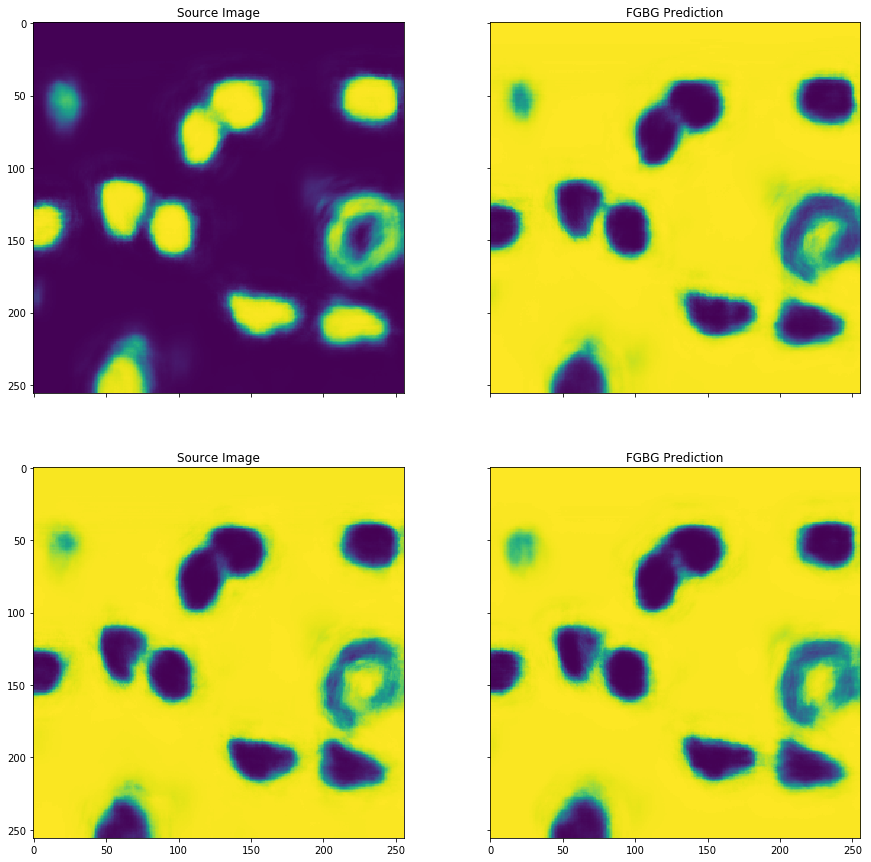

In [117]:

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(predictnp[0,0,0, ..., 1])
ax[0].set_title('Source Image')

ax[1].imshow(predictnp[1,0,1, ..., 0])
ax[1].set_title('FGBG Prediction')

ax[2].imshow(predictnp[2,0,2, ..., 0])
ax[2].set_title('Source Image')

ax[3].imshow(predictnp[3,0,2, ..., 0])
ax[3].set_title('FGBG Prediction')

In [118]:
print(predictnp.shape)
print(predictnp[0][0].shape)

(4, 1, 3, 256, 256, 2)
(3, 256, 256, 2)


In [120]:
temp = predictnp[0][0]
print(temp.shape)

(3, 256, 256, 2)


In [123]:
temp3D = temp[:,:,:,1]

In [124]:
print(temp.shape)

(3, 256, 256, 2)


In [127]:
predict_lbl = label((temp[:,:,:,1]>0.5).astype('int'))

In [135]:
print(y_test.shape)
y_test[0,:,:,:,0].shape

(1, 3, 256, 256, 1)


(3, 256, 256)

In [136]:
y_true = label(y_test[0,:,:,:,0].astype('int'))
y_pred = label(predict_lbl)

In [137]:
y_test2 = y_test[0]
y_test2.shape

(3, 256, 256, 1)

In [138]:
m = metrics.Metrics('singleton',seg=True)
m.calc_object_stats(y_true,y_pred)


INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 31
Number of predicted cells:	 30

True positives:  23	Accuracy:   74.19%

False positives: 3	Perc Error: 42.86%
False negatives: 0	Perc Error: 0.0%
Merges:		 4	Perc Error: 57.14%
Splits:		 0	Perc Error: 0.0%

SEG: 0.6493 

